# Dynamic Factor Model 

Resources: http://www.chadfulton.com/topics/dfm_coincident.html
 

This notebook explores a state-space model using the python statsmodels library 
Link: https://www.statsmodels.org/stable/index.html

The goal of the notebook is to use the template in Chad Fulton's blog post to model economic indicator time series. <br>
The data set includes five economic time series: quarterly U.S. unemployment, GNP (Gross National Product), consumption, and government and private investment, from 1948-III to 1988-II.

**Note:** <br>
The data doesnt include the quaters, so, fred data is pulled for the same period and concatenated to get correct dates. This is a hack and I am sure there is a more elegant way of doing this with pandas.

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sn

np.set_printoptions(precision=4, suppress=True, linewidth=120)

/home/ian/anaconda3/envs/siraj_ml/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
#!conda install pandas_datareader

### Get fred data and get quartlery dates

In [4]:
from pandas_datareader.data import DataReader

In [5]:
# Get the datasets from FRED
start = '1948-08-01'
end = '1988-07-01'
gnp_data = DataReader('GNP', 'fred', start=start, end=end)

In [6]:
# Look at first two rows
gnp_data.head(2) 

,GNP
DATE,
1948-10-01,282.127
1949-01-01,276.756


In [7]:
# Look at last two rows
gnp_data.tail(2)

,GNP
DATE,
1988-04-01,5230.523
1988-07-01,5319.648


In [8]:
#160 observations
gnp_data.shape

(160, 1)

### Data
containing five economic time series: quarterly U.S. unemployment, GNP (Gross National Product), consumption, and government and private investment, from 1948-III to 1988-II.

In [17]:
data = pd.read_csv("../data/econ5.csv")

In [18]:
data.columns

Index(['Unnamed: 0', 'unemp', 'gnp', 'consum', 'govinv', 'prinv'], dtype='object')

In [9]:
gnp_data = gnp_data.reset_index()

In [10]:
#Drop an index column
data = data.drop(columns=['Unnamed: 0'])

In [11]:
data['date'] = gnp_data['DATE']

In [12]:
#Set date as index - this is used by the state-space model later
data = data.set_index(data['date'])

In [13]:
data.head(2)

,unemp,gnp,consum,govinv,prinv,date
date,,,,,,
1948-10-01,3.9,1106.1,681.4,180.4,210.3,1948-10-01
1949-01-01,3.6,1116.3,682.9,181.3,211.5,1949-01-01


### Plot raw data

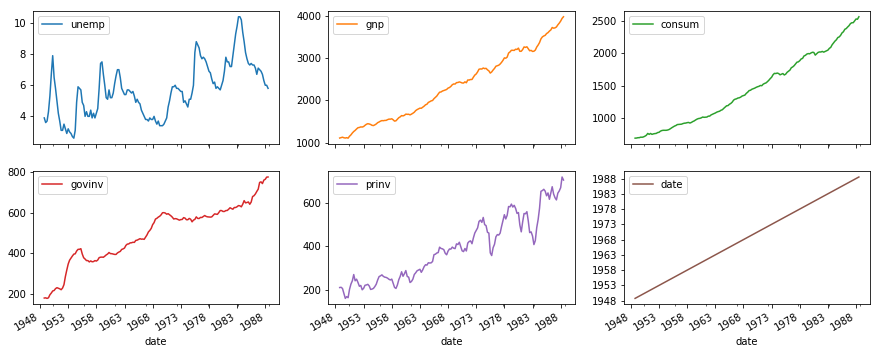

In [15]:
data.loc[:, :].plot(subplots=True, layout=(2, 3), figsize=(15, 6));

### Create the differenced data to stationarize

I know from previous analysis in stata that differencing will stationarize series.

In [17]:
#Create the differenced series to stationarize
# May want to try log differenced later
data['unemp_diff'] = data['unemp'].diff()
data['gnp_diff'] = data['gnp'].diff()
data['consum_diff'] = data['consum'].diff()
data['govinv_diff'] = data['govinv'].diff()
data['prinv_diff'] = data['prinv'].diff()

In [ ]:
### Plot the differenced data

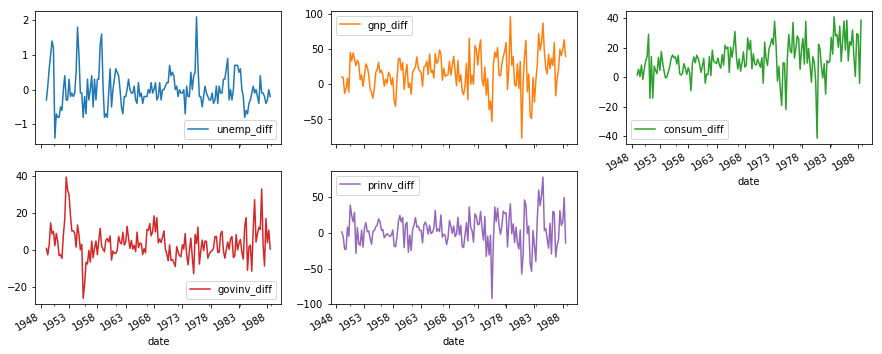

In [19]:
data.loc[:, ['unemp_diff', 'gnp_diff',
       'consum_diff', 'govinv_diff', 'prinv_diff']].plot(subplots=True, layout=(2, 3), figsize=(15, 6));

### Build our dynamic factor model with Statsmodels 

In [22]:
k_factors = 1 # 1 unobserved factor
factor_order = 4 # we have reason to belive lag 4 becuase quarterly data
error_var = False # error evolves independently (default)
error_order = 4 # Guess that error is autocorelated AR(4) Need to check

### Parameter estimation

In [50]:
data.head()

,unemp,gnp,consum,govinv,prinv,date,unemp_diff,gnp_diff,consum_diff,govinv_diff,prinv_diff
date,,,,,,,,,,,
1948-10-01,3.9,1106.1,681.4,180.4,210.3,1948-10-01,NaN,NaN,NaN,NaN,NaN
1949-01-01,3.6,1116.3,682.9,181.3,211.5,1949-01-01,-0.3,10.2,1.5,0.9,1.2
1949-04-01,3.7,1125.5,688.3,178.7,206.0,1949-04-01,0.1,9.2,5.4,-2.6,-5.5
1949-07-01,4.3,1112.4,688.7,181.6,183.2,1949-07-01,0.6,-13.1,0.4,2.9,-22.8
1949-10-01,5.3,1105.9,696.9,196.3,160.2,1949-10-01,1.0,-6.5,8.2,14.7,-23.0


In [74]:
#lets remove the last 8 observations for forecasting
train_sample = data.iloc[:-8,-5:]
test_sample = data.iloc[-8:, -5:]

In [38]:
#test_sample = test_sample.drop(columns=['date'])

In [76]:
train_sample = train_sample.fillna(method ='bfill')
#test_sample = test_sample.fillna(method ='bfill')

In [77]:
train_sample.isna().sum()

unemp_diff     0
gnp_diff       0
consum_diff    0
govinv_diff    0
prinv_diff     0
dtype: int64

In [78]:
train_sample = train_sample.apply(pd.to_numeric, errors='coerce')

In [79]:
# get endogenous data
endog = train_sample

## Dynamic Factor

**Dynamic factor statespace model ** 

**Documentation:** http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.dynamic_factor.DynamicFactor.html <br>
** Reference:** <i> Lutkepohl, Helmut. 2007. New Introduction to Multiple Time Series Analysis. Berlin: Springer. </i> <br>
<br>
**General dynamic factor model:**
$$% <![CDATA[
\begin{align}
y_t & = \Lambda f_t + B x_t + u_t \\
f_t & = A_1 f_{t-1} + \dots + A_p f_{t-p} + \eta_t \qquad \eta_t \sim N(0, I)\\
u_t & = C_1 u_{t-1} + \dots + C_1 f_{t-q} + \varepsilon_t \qquad \varepsilon_t \sim N(0, \Sigma)
\end{align} %]]>$$

$y_t$ = observed data <br>
$f_t$ = unobserved factors <br>
$X_t$ = exogenous variables (optional) <br>
$u_t$ = idiosyncratic process <br>

In [85]:
model = sm.tsa.DynamicFactor(endog, k_factors=1, factor_order=4, error_order=4, rcond=None)
inital_res = model.fit(method='powell', disp=False)
res = model.fit(inital_res.params)

/home/ian/anaconda3/envs/siraj_ml/lib/python3.6/site-packages/statsmodels/tsa/vector_ar/var_model.py:461: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params = np.linalg.lstsq(z, y_sample)[0]


In [86]:
#Summary - single unknown factor
res.summary(separate_params=False)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                     Statespace Model Results                                                     
==================================================================================================================================
Dep. Variable:     ['unemp_diff', 'gnp_diff', 'consum_diff', 'govinv_diff', 'prinv_diff']   No. Observations:                  153
Model:                                                  DynamicFactor(factors=1, order=4)   Log Likelihood               -2464.307
                                                                           + AR(4) errors   AIC                           4996.614
Date:                                                                    Sun, 01 Apr 2018   BIC                           5099.649
Time:                                                                            16:06:37   HQIC                          5038.469
Sample:                                                                        10-01-1948                                         
                                                                             - 10-01-1986                                         
Covariance Type:                                                                      opg                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
loading.f1.unemp_diff                0.2064      0.052      3.972      0.000       0.105       0.308
loading.f1.gnp_diff                -24.0289      1.634    -14.709      0.000     -27.231     -20.827
loading.f1.consum_diff              -5.7562      0.741     -7.768      0.000      -7.208      -4.304
loading.f1.govinv_diff               0.5411      0.896      0.604      0.546      -1.214       2.296
loading.f1.prinv_diff              -16.9267      1.539    -10.999      0.000     -19.943     -13.910
sigma2.unemp_diff                    0.1530      0.017      8.974      0.000       0.120       0.186
sigma2.gnp_diff                      0.0023      0.123      0.019      0.985      -0.240       0.244
sigma2.consum_diff                  87.1527     10.920      7.981      0.000      65.750     108.555
sigma2.govinv_diff                  52.6547      5.307      9.923      0.000      42.254      63.055
sigma2.prinv_diff                  157.1854     24.336      6.459      0.000     109.488     204.883
L1.f1.f1                             0.2803      0.102      2.753      0.006       0.081       0.480
L2.f1.f1                             0.1835      0.080      2.290      0.022       0.026       0.340
L3.f1.f1                            -0.0755      0.086     -0.878      0.380      -0.244       0.093
L4.f1.f1                            -0.0299      0.094     -0.319      0.750      -0.214       0.154
L1.e(unemp_diff).e(unemp_diff)       0.2872      0.090      3.193      0.001       0.111       0.463
L2.e(unemp_diff).e(unemp_diff)       0.0478      0.100      0.476      0.634      -0.149       0.245
L3.e(unemp_diff).e(unemp_diff)      -0.1675      0.116     -1.441      0.150      -0.395       0.060
L4.e(unemp_diff).e(unemp_diff)      -0.1325      0.118     -1.120      0.263      -0.364       0.099
L1.e(gnp_diff).e(gnp_diff)           1.3220      1.137      1.162      0.245      -0.907       3.551
L2.e(gnp_diff).e(gnp_diff)          -0.0396      0.421     -0.094      0.925      -0.865       0.786
L3.e(gnp_diff).e(gnp_diff)          -0.0254      0.359     -0.071      0.944      -0.728       0.678
L4.e(gnp_diff).e(gnp_diff)          -0.2571      1.198     -0.215      0.830      -2.606       2.092
L1.e(consum_diff).e(consum_diff)     0.0955      0.087      1.094      0.274      -0.076       0.267
L2.e(consum_diff

### Make Latex table
Link: https://economics.stackexchange.com/questions/11774/outputting-regressions-as-table-in-python-similar-to-outreg-in-stata

In [87]:
beginingtex = """\\documentclass{report}
                \\usepackage{bootabs}
                \\begin{document}"""
endtex = "\end{document}"

In [88]:
f = open('single_factor.tex','w')
f.write(beginingtex)
f.write(res.summary().as_latex())
f.write(endtex)
f.close()

### Plot Factor

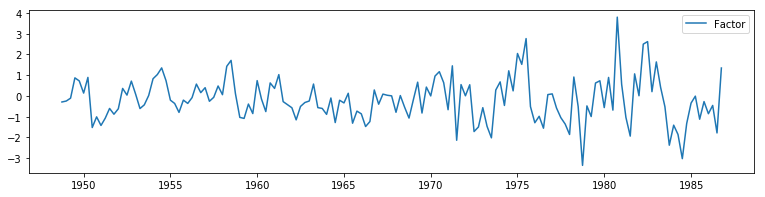

In [89]:
#single factor
fig, ax = plt.subplots(figsize=(13,3))

# Plot the factor
dates = endog.index._mpl_repr()
ax.plot(dates, res.factors.filtered[0], label='Factor')
ax.legend()

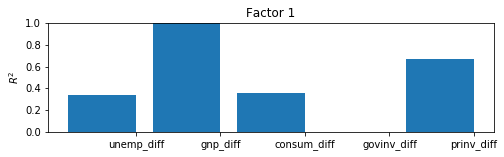

In [90]:
res.plot_coefficients_of_determination(figsize=(8,2));
